In [2]:
import tifffile
from matplotlib import pyplot as plt
import numpy as np
import deeptrack as dt
import random
import tensorflow as tf
import pandas as pd

/home/gideon/miniconda3/lib/python3.9/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/home/gideon/miniconda3/lib/python3.9/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2023-11-03 16:19:50.901435: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 16:19:50.985431: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 16:19:50.986684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 16:19:

In [3]:
import tifffile

#tiff_path = r'../data/experimental/Spike_HighDensity.tiff'

tiff_path = r'../data/simulated/Sim_results_High.tiff'
csv_path = r'../data/simulated/Sim_MedDensity.csv'

images = tifffile.imread(tiff_path, key=range(300, 2000, 1))

print(images.min())

gt = pd.read_csv(csv_path)
print(images.shape)

#images = np.abs((images-np.min(images))/(np.max(images)-np.min(images)) - 1)
images = images - np.mean(images)
images = images / np.std(images, axis=(0, 1, 2), keepdims=True) / 3

print(images.min())
#images = torch.unsqueeze(images, axis=2)

-0.05472
(1700, 81, 128)
-4.48


In [217]:
gt = gt.drop(['D', 'particle', 'Mass'], axis=1)

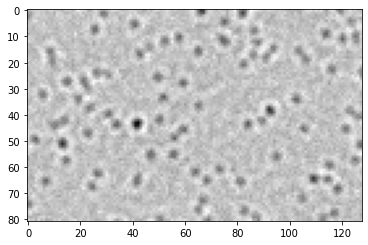

In [4]:
t, x, y, w = (1600, 0, 0, 256)
crop0 = images[t, y:y+w, x:x+w].astype(np.float64)
plt.imshow(crop0, cmap='gray')
#plt.axis("off")

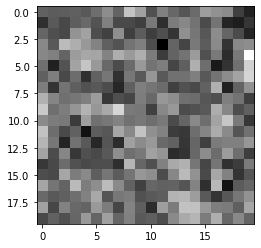

In [286]:
t, x, y, w = (0, 75, 10, 20)
crop1 = images[t, y:y+w, x:x+w].astype(np.float64)
plt.imshow(crop1, cmap='gray')
#plt.axis("off")

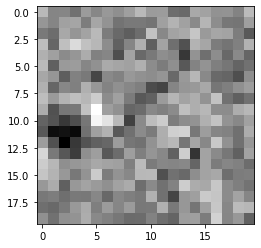

In [6]:
t, x, y, w = (5, 0, 10, 20)
crop2 = images[t, y:y+w, x:x+w].astype(np.float64)
plt.imshow(crop2, cmap='gray')
#plt.axis("off")

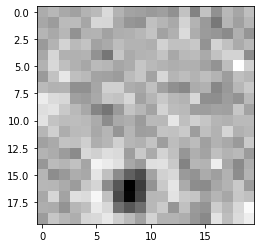

In [7]:
t, x, y, w = (3, 44, 61, 20)
crop3 = images[t, y:y+w, x:x+w].astype(np.float64)
plt.imshow(crop3, cmap='gray')
#plt.axis("off")

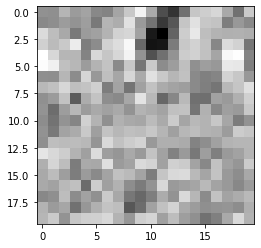

In [306]:
t, x, y, w = (3, 50, 35, 20)
crop4 = images[t, y:y+w, x:x+w].astype(np.float64)
plt.imshow(crop4, cmap='gray')

## LOADSTAR

In [323]:
#crops = [crop0, crop1, crop2, crop3, crop4]
crops = [crop4]

train_set =   (
    dt.Value(lambda: np.array(random.choice(crops)))   
    >> dt.Affine(translate=lambda:np.random.uniform(-4, 4, 2))
    >> dt.Affine(scale=lambda:np.random.uniform(0.9, 1.2, 2))
    >> dt.Affine(rotate=lambda:np.random.uniform(0, np.pi*2))
    >> dt.Affine(shear=lambda:np.random.uniform(0, 0.6))
    >> dt.Add(lambda: np.random.randn() * 0.1)
    #>> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.2))  
    #>> dt.Multiply(lambda: np.random.uniform(1.2, 1.2))
)

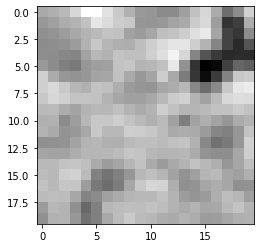

In [324]:
plt.imshow(train_set.resolve(), cmap='gray')

In [325]:
#generator = dt.models.lodestar.LodeSTARGenerator(
#    training_set,
#    3,
#    (group, equivariance), 
#    batch_size=8, 
#    min_data_size=400, 
#    max_data_size=401
#)
name = "size_20_AffineAdd"

loadstar = dt.models.LodeSTAR(input_shape=(None, None, 1))
loadstar.load_weights(f"../data/weights/loadstar/{name}/{name}")

In [326]:
loadstar.fit(
    train_set,
    epochs=30,
    batch_size=8,
)


Generating 162 / 160 samples before starting training
Epoch 1/30
162/162 [==============================] - 31s 38ms/step - total_loss: 1.8182 - consistency_loss: 0.3715
Epoch 2/30
162/162 [==============================] - 26s 163ms/step - total_loss: 1.2252 - consistency_loss: 0.1359                                       
Epoch 3/30
162/162 [==============================] - 25s 153ms/step - total_loss: 1.1341 - consistency_loss: 0.1240                                       
Epoch 4/30
162/162 [==============================] - 11s 69ms/step - total_loss: 1.0854 - consistency_loss: 0.0916                                      
Epoch 5/30
162/162 [==============================] - 27s 166ms/step - total_loss: 1.0087 - consistency_loss: 0.0864                                       
Epoch 6/30
162/162 [==============================] - 21s 129ms/step - total_loss: 1.0229 - consistency_loss: 0.0795                                      
Epoch 7/30
162/162 [==============================] -

In [317]:
#May need to tune these to get optimal performance!
alpha = 0.20
cutoff = 0.8

frame_index = 5
image = images[frame_index, :, :]



detections = loadstar.predict_and_detect(image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff)[0]

#gt_timestep = gt[gt['time'] == frame_index*4+300]

plt.figure(figsize=(15, 15))
plt.imshow(image, cmap='gray')
# WHY IS GT OFSET BY X-22 and Y-20??
#plt.scatter(gt_timestep['x']-22, gt_timestep['y']-20, color='b')
plt.scatter(detections[:, 1], detections[:, 0], color="r")

1/1 [==============================] - 0s 194ms/step


ValueError: h = 0 is ambiguous, use local_maxima() instead?

1/1 [==============================] - 0s 24ms/step


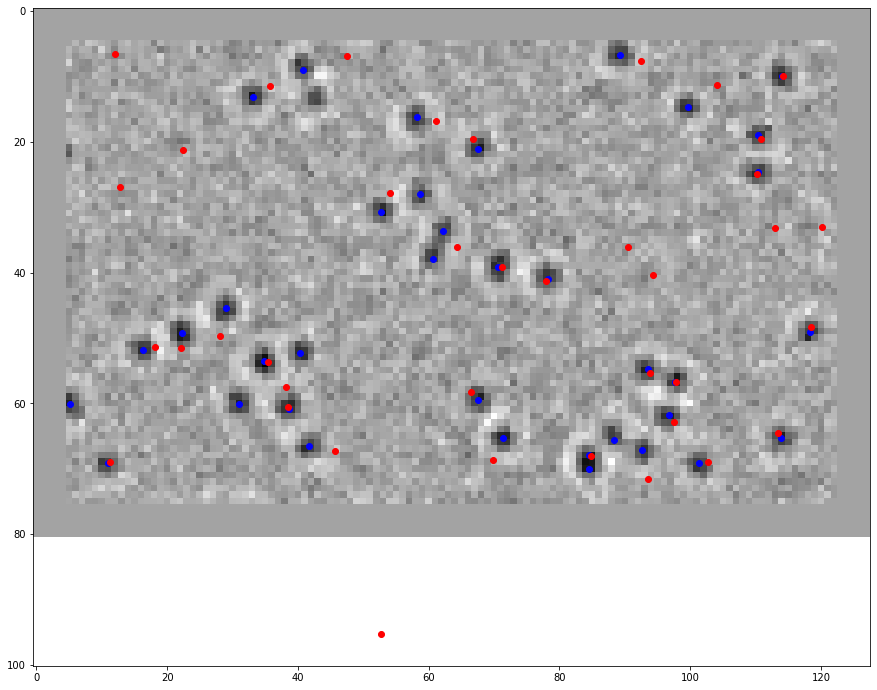

In [322]:
#May need to tune these to get optimal performance!
alpha = 0.99
cutoff = 0.9

frame_index = 3
image = images[frame_index, :, :]



detections = loadstar.predict_and_detect(image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff)[0]

gt_timestep = gt[gt['time'] == frame_index*1+300][['y', 'x']].to_numpy()
gt_timestep[:, 1] -= 22
gt_timestep[:, 0] -= 20

detections = np.delete(detections, np.where((detections[:, 0] < 5) | (detections[:, 1] < 5 | (detections[:, 1] > 123) | (detections[:, 0] > 75)))[0], axis=0)
gt_timestep = np.delete(gt_timestep, np.where((gt_timestep[:, 0] < 5) | (gt_timestep[:, 1] < 5) | (gt_timestep[:, 1] > 123) | (gt_timestep[:, 0] > 75))[0], axis=0)

plt.figure(figsize=(15, 15))

display_image = image.copy()

display_image[:5, :] = 0
display_image[-5:, :] = 0
display_image[:, :5] = 0
display_image[:, -5:] = 0

plt.imshow(display_image, cmap='gray')
# WHY IS GT OFSET BY X-22 and Y-20??
plt.scatter(gt_timestep[:, 1], gt_timestep[:, 0], color='b')
plt.scatter(detections[:, 1], detections[:, 0], color="r")

In [284]:
detections_all = loadstar.predict_and_detect(images, alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")

print(len(detections_all))

54/54 [==============================] - 9s 167ms/step
1700


In [283]:
name = "size_30_AffineAdd"

loadstar.save_weights(f"../data/weights/loadstar/{name}/{name}")


### TEST

In [298]:
def distance_matrix(matrix_a, matrix_b):
    expanded_a = np.expand_dims(matrix_a, 1)  # Shape: (n, 1, m)
    expanded_b = np.expand_dims(matrix_b, 0)  # Shape: (1, n, m)
    #expanded_a = np.transpose(expanded_a, (0, 1, 2))
    square_difference = np.square(
        expanded_a - expanded_b
    )  # Element-wise squared difference
    distances = np.sum(square_difference, axis=2)
    distances = np.sqrt(distances)
    return distances

mses = []
missed_detections_total = 0
false_detections_total = 0
true_detections_total = 0
for frame_index in range(len(detections_all)):

    detections = detections_all[frame_index]
    gt_timestep = gt[gt['time'] == frame_index*1+300][['y', 'x']].to_numpy()
    gt_timestep[:, 1] -= 22
    gt_timestep[:, 0] -= 20

    detections = np.delete(detections, np.where((detections[:, 0] < 5) | (detections[:, 1] < 5 | (detections[:, 1] > 123) | (detections[:, 0] > 75)))[0], axis=0)
    gt_timestep = np.delete(gt_timestep, np.where((gt_timestep[:, 0] < 5) | (gt_timestep[:, 1] < 5) | (gt_timestep[:, 1] > 123) | (gt_timestep[:, 0] > 75))[0], axis=0)

    distances = distance_matrix(detections, gt_timestep)
    min_distance = np.argmin(distances, axis=0)
    min_distance_2 = np.argmin(distances, axis=1)

    tps = []
    missed_detections = 0
    false_detections = 0
    true_detections = 0
    for i_dist, dist_1 in enumerate(min_distance):
        if i_dist == min_distance_2[dist_1]:
            tps.append(i_dist)
        else:
            missed_detections += 1

    for i_dist, dist_2 in enumerate(min_distance_2):
        if i_dist == min_distance[dist_2]:
            true_detections += 1
        else:
            false_detections += 1

    
    true_detections_total += true_detections
    false_detections_total += false_detections
    missed_detections_total += missed_detections

    se = np.min(distances, axis=0)[tps]
    mses.append(np.mean(se))

    #plt.figure(figsize=(15, 15))
    #plt.imshow(images[frame_index], cmap='gray')
    #plt.scatter(gt_timestep[:, 1], gt_timestep[:, 0], color='b')
    #plt.scatter(detections[:, 1], detections[:, 0], color="r")
    #plt.scatter(gt_timestep[tps, 1], gt_timestep[tps, 0], color='y')

    #break

print(true_detections_total)
print(false_detections_total)
print(missed_detections_total)

print()

print(false_detections_total / (false_detections_total + true_detections_total))
print(missed_detections_total / (missed_detections_total + true_detections_total))

print(np.mean(mses))




49894
6989
5719

0.12286623420002461
0.10283566791937138
0.360499140875948
